Installing required packages...
✅ Installed chonkie
✅ Installed jinja2
✅ Installed matplotlib
✅ Installed networkx
✅ Installed numpy
✅ Installed openai>=1.0.0
✅ Installed plotly
✅ Installed pydantic>=2.0.0
✅ Installed rapidfuzz
✅ Installed scipy
✅ Installed tenacity
✅ Installed tiktoken
✅ Installed pandas
✅ Installed datasets<3.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Paste your OpenAI API key here: ··········
🚀 Starting Temporal Knowledge Graph Demo

📚 Creating sample transcript data...
Created 2 sample transcripts

💾 Setting up database...
Database initialized

🤖 Initializing Temporal Agent...
Agent ready

⚙️ Processing transcripts...

Processing AMD transcript...
  Extracted 1 facts from chunk

Processing NVIDIA transcript...
  Extracted 1 facts from chunk

✅ Total facts extracted: 2

🕸️ Building knowledge graph...
Graph created with 3 nodes and 2 edges

📊 Visualizing knowledge graph...


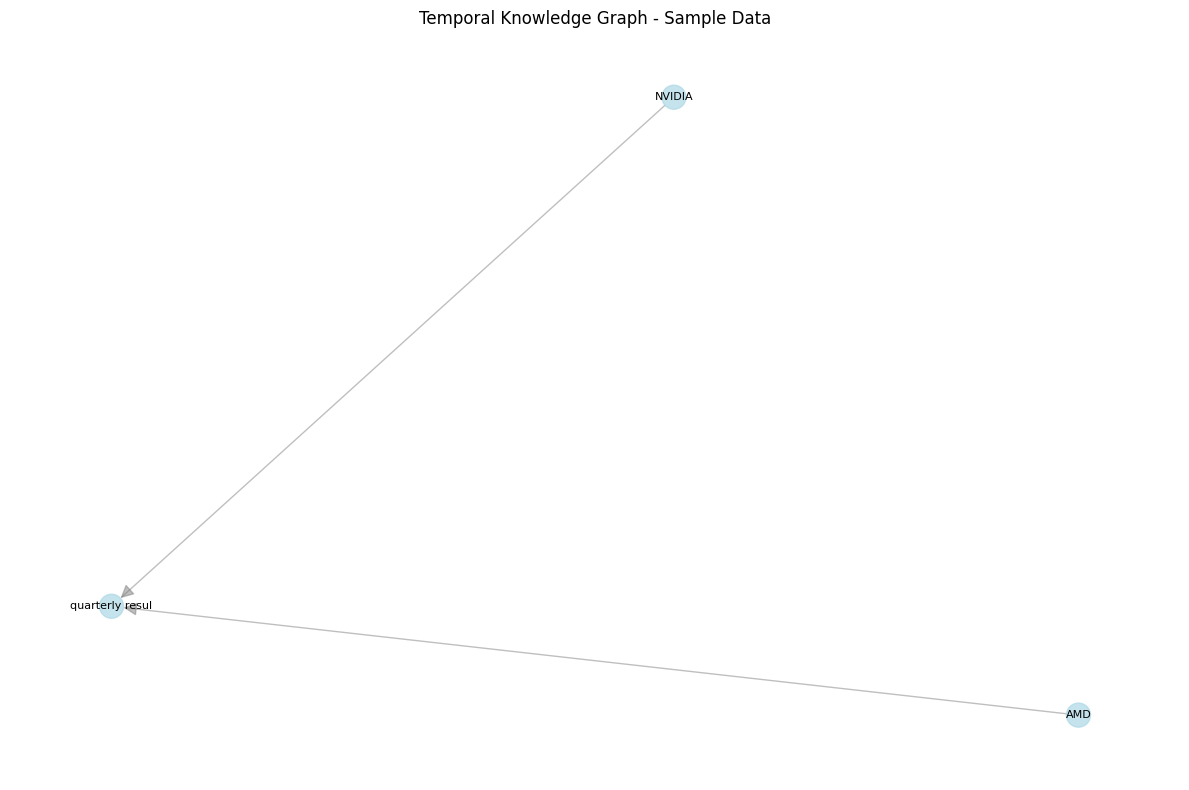


🔍 Demonstrating retrieval capabilities...

--- Query: AMD ---
Found 1 relationships for 'AMD':

1. AMD -- REPORTED --> quarterly results
   Statement: Information extracted from AMD transcript
   Valid from: 2020-10-27T00:00:00

--- Query: NVIDIA with predicate LAUNCHED ---
No relationships found for NVIDIA with predicate LAUNCHED

--- Query: revenue ---
No information found for entity: revenue

📈 Graph Statistics:
  Nodes: 3
  Edges: 2
  Average degree: 1.33

🔗 Top connected entities:
  quarterly results: 2 connections
  AMD: 1 connections
  NVIDIA: 1 connections

🎉 Demo completed successfully!

🎯 Demo Variables Available:
  G - Knowledge graph (NetworkX)
  facts - Extracted facts list
  conn - Database connection
  simple_factual_qa(G, entity, predicate) - Query function


In [ ]:
# -*- coding: utf-8 -*-
"""temporal_agents_with_knowledge_graphs_colab.py

Updated version of the Temporal Knowledge Graph Cookbook for Google Colab
"""

# Initial setup and installations
import subprocess
import sys

def install_packages():
    """Install required packages for Colab environment"""
    packages = [
        "chonkie",
        "jinja2",
        "matplotlib",
        "networkx",
        "numpy",
        "openai>=1.0.0",
        "plotly",
        "pydantic>=2.0.0",
        "rapidfuzz",
        "scipy",
        "tenacity",
        "tiktoken",
        "pandas",
        "datasets<3.0"
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
            print(f"✅ Installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")

# Run installation
print("Installing required packages...")
install_packages()

# Core imports
import os
import json
import uuid
import pickle
import sqlite3
import asyncio
import logging
import time
import re
import string
from collections import Counter, defaultdict
from collections.abc import Coroutine
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
from enum import StrEnum

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pydantic import BaseModel, Field, field_validator, model_validator, ValidationError
from jinja2 import DictLoader, Environment
from openai import AsyncOpenAI
from tenacity import retry, stop_after_attempt, wait_random_exponential
from rapidfuzz import fuzz
from scipy.spatial.distance import cosine
from tqdm import tqdm

# Check Python version
import sys
print(f"Python version: {sys.version}")

# Set up OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    import getpass
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste your OpenAI API key here: ")

# Initialize OpenAI client
client = AsyncOpenAI()

# =============================================================================
# CORE DATA MODELS
# =============================================================================

class TemporalType(StrEnum):
    """Enumeration of temporal types of statements."""
    ATEMPORAL = "ATEMPORAL"
    STATIC = "STATIC"
    DYNAMIC = "DYNAMIC"

class StatementType(StrEnum):
    """Enumeration of statement types for statements."""
    FACT = "FACT"
    OPINION = "OPINION"
    PREDICTION = "PREDICTION"

class Predicate(StrEnum):
    """Enumeration of normalised predicates."""
    IS_A = "IS_A"
    HAS_A = "HAS_A"
    LOCATED_IN = "LOCATED_IN"
    HOLDS_ROLE = "HOLDS_ROLE"
    PRODUCES = "PRODUCES"
    SELLS = "SELLS"
    LAUNCHED = "LAUNCHED"
    DEVELOPED = "DEVELOPED"
    ADOPTED_BY = "ADOPTED_BY"
    INVESTS_IN = "INVESTS_IN"
    COLLABORATES_WITH = "COLLABORATES_WITH"
    SUPPLIES = "SUPPLIES"
    HAS_REVENUE = "HAS_REVENUE"
    INCREASED = "INCREASED"
    DECREASED = "DECREASED"
    RESULTED_IN = "RESULTED_IN"
    TARGETS = "TARGETS"
    PART_OF = "PART_OF"
    DISCONTINUED = "DISCONTINUED"
    SECURED = "SECURED"

class Chunk(BaseModel):
    """A chunk of text from an earnings call."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    text: str
    metadata: Dict[str, Any]

class Transcript(BaseModel):
    """A transcript of a company earnings call."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    text: str
    company: str
    date: datetime
    quarter: Optional[str] = None
    chunks: Optional[List[Chunk]] = None

    @field_validator("date", mode="before")
    @classmethod
    def to_datetime(cls, d: Any) -> datetime:
        """Convert input to a datetime object."""
        if isinstance(d, datetime):
            return d
        if hasattr(d, "isoformat"):
            return datetime.fromisoformat(d.isoformat())
        return datetime.fromisoformat(str(d))

class RawStatement(BaseModel):
    """Model representing a raw statement with type and temporal information."""
    statement: str
    statement_type: StatementType
    temporal_type: TemporalType

    @field_validator("temporal_type", mode="before")
    @classmethod
    def _parse_temporal_label(cls, value: str | None) -> TemporalType:
        if value is None:
            return TemporalType.ATEMPORAL
        cleaned_value = value.strip().upper()
        try:
            return TemporalType(cleaned_value)
        except ValueError as e:
            raise ValueError(f"Invalid temporal type: {value}. Must be one of {[t.value for t in TemporalType]}") from e

    @field_validator("statement_type", mode="before")
    @classmethod
    def _parse_statement_label(cls, value: str | None = None) -> StatementType:
        if value is None:
            return StatementType.FACT
        cleaned_value = value.strip().upper()
        try:
            return StatementType(cleaned_value)
        except ValueError as e:
            raise ValueError(f"Invalid statement type: {value}. Must be one of {[t.value for t in StatementType]}") from e

class RawStatementList(BaseModel):
    """Model representing a list of raw statements."""
    statements: List[RawStatement]

class RawTemporalRange(BaseModel):
    """Model representing the raw temporal validity range as strings."""
    valid_at: Optional[str] = Field(..., json_schema_extra={"format": "date-time"})
    invalid_at: Optional[str] = Field(..., json_schema_extra={"format": "date-time"})

class RawTriplet(BaseModel):
    """Model representing a subject-predicate-object triplet."""
    subject_name: str
    subject_id: int
    predicate: Predicate
    object_name: str
    object_id: int
    value: Optional[str] = None

class RawEntity(BaseModel):
    """Model representing an entity (for entity resolution)."""
    entity_idx: int
    name: str
    type: str = ""
    description: str = ""

class RawExtraction(BaseModel):
    """Model representing a triplet extraction."""
    triplets: List[RawTriplet]
    entities: List[RawEntity]

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def parse_date_str(date_str: str) -> Optional[datetime]:
    """Parse a date string into a datetime object."""
    if not date_str or date_str.lower() in ('none', 'null', ''):
        return None

    # Try common date formats
    formats = [
        "%Y-%m-%dT%H:%M:%S.%fZ",
        "%Y-%m-%dT%H:%M:%SZ",
        "%Y-%m-%dT%H:%M:%S",
        "%Y-%m-%d %H:%M:%S",
        "%Y-%m-%d",
        "%Y/%m/%d",
        "%d/%m/%Y",
        "%m/%d/%Y"
    ]

    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue

    # If all formats fail, try to parse with dateutil if available
    try:
        from dateutil.parser import parse
        return parse(date_str)
    except:
        return None

def safe_iso(dt: Optional[datetime]) -> Optional[str]:
    """Safely convert datetime to ISO string."""
    return dt.isoformat() if dt else None

# =============================================================================
# DATABASE INTERFACE (Simplified for Colab)
# =============================================================================

def make_connection(memory: bool = True, refresh: bool = False, db_path: str = "knowledge_graph.db") -> sqlite3.Connection:
    """Create SQLite database connection with required tables."""

    if memory:
        conn = sqlite3.connect(":memory:")
    else:
        if refresh and os.path.exists(db_path):
            os.remove(db_path)
        conn = sqlite3.connect(db_path)

    # Create tables
    conn.executescript("""
        CREATE TABLE IF NOT EXISTS transcripts (
            id TEXT PRIMARY KEY,
            text TEXT,
            company TEXT,
            date TEXT,
            quarter TEXT
        );

        CREATE TABLE IF NOT EXISTS chunks (
            id TEXT PRIMARY KEY,
            transcript_id TEXT,
            text TEXT,
            metadata TEXT,
            FOREIGN KEY (transcript_id) REFERENCES transcripts (id)
        );

        CREATE TABLE IF NOT EXISTS events (
            id TEXT PRIMARY KEY,
            chunk_id TEXT,
            statement TEXT,
            embedding BLOB,
            triplets TEXT,
            statement_type TEXT,
            temporal_type TEXT,
            valid_at TEXT,
            invalid_at TEXT,
            created_at TEXT,
            expired_at TEXT,
            invalidated_by TEXT,
            FOREIGN KEY (chunk_id) REFERENCES chunks (id)
        );

        CREATE TABLE IF NOT EXISTS triplets (
            id TEXT PRIMARY KEY,
            event_id TEXT,
            subject_name TEXT,
            subject_id TEXT,
            predicate TEXT,
            object_name TEXT,
            object_id TEXT,
            value TEXT,
            FOREIGN KEY (event_id) REFERENCES events (id)
        );

        CREATE TABLE IF NOT EXISTS entities (
            id TEXT PRIMARY KEY,
            name TEXT,
            resolved_id TEXT
        );

        CREATE TABLE IF NOT EXISTS canonical_entities (
            id TEXT PRIMARY KEY,
            name TEXT,
            type TEXT,
            description TEXT
        );
    """)

    conn.commit()
    return conn

def insert_transcript(conn: sqlite3.Connection, transcript_data: Dict[str, Any]) -> None:
    """Insert transcript into database."""
    conn.execute("""
        INSERT OR REPLACE INTO transcripts (id, text, company, date, quarter)
        VALUES (?, ?, ?, ?, ?)
    """, (
        transcript_data["id"],
        transcript_data["text"],
        transcript_data["company"],
        transcript_data["date"].isoformat() if isinstance(transcript_data["date"], datetime) else transcript_data["date"],
        transcript_data.get("quarter")
    ))

def insert_chunk(conn: sqlite3.Connection, chunk_data: Dict[str, Any]) -> None:
    """Insert chunk into database."""
    conn.execute("""
        INSERT OR REPLACE INTO chunks (id, transcript_id, text, metadata)
        VALUES (?, ?, ?, ?)
    """, (
        chunk_data["id"],
        chunk_data["transcript_id"],
        chunk_data["text"],
        chunk_data["metadata"]
    ))

def insert_event(conn: sqlite3.Connection, event_data: Dict[str, Any]) -> None:
    """Insert event into database."""
    conn.execute("""
        INSERT OR REPLACE INTO events (
            id, chunk_id, statement, embedding, triplets, statement_type,
            temporal_type, valid_at, invalid_at, created_at, expired_at, invalidated_by
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        event_data["id"],
        event_data["chunk_id"],
        event_data["statement"],
        event_data.get("embedding"),
        event_data["triplets"],
        event_data["statement_type"],
        event_data["temporal_type"],
        event_data["valid_at"],
        event_data["invalid_at"],
        event_data["created_at"],
        event_data["expired_at"],
        event_data["invalidated_by"]
    ))

def insert_triplet(conn: sqlite3.Connection, triplet_data: Dict[str, Any]) -> None:
    """Insert triplet into database."""
    conn.execute("""
        INSERT OR REPLACE INTO triplets (
            id, event_id, subject_name, subject_id, predicate,
            object_name, object_id, value
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        triplet_data["id"],
        triplet_data["event_id"],
        triplet_data["subject_name"],
        triplet_data["subject_id"],
        triplet_data["predicate"],
        triplet_data["object_name"],
        triplet_data["object_id"],
        triplet_data["value"]
    ))

def insert_entity(conn: sqlite3.Connection, entity_data: Dict[str, Any]) -> None:
    """Insert entity into database."""
    conn.execute("""
        INSERT OR REPLACE INTO entities (id, name, resolved_id)
        VALUES (?, ?, ?)
    """, (
        entity_data["id"],
        entity_data["name"],
        entity_data["resolved_id"]
    ))

# =============================================================================
# SIMPLIFIED DEMO DATA
# =============================================================================

def create_sample_data() -> List[Transcript]:
    """Create sample transcript data for demonstration."""

    sample_transcripts = [
        {
            "text": """
            AMD Q3 2020 Earnings Call Transcript

            Good morning everyone. I'm Lisa Su, CEO of AMD. Today I'm excited to share our Q3 2020 results.

            AMD reported record quarterly revenue of $2.8 billion in Q3 2020, up 56% year-over-year.
            Our data center revenue increased significantly driven by strong EPYC processor adoption.

            We launched our new Ryzen 5000 series processors in October 2020, featuring our advanced
            Zen 3 architecture. These processors deliver industry-leading performance for gaming and
            content creation.

            Looking ahead, we expect continued growth in our server and data center business. We are
            investing heavily in AI and machine learning capabilities.
            """,
            "company": "AMD",
            "date": "2020-10-27",
            "quarter": "Q3 2020"
        },
        {
            "text": """
            NVIDIA Q3 2020 Earnings Call Transcript

            Thank you for joining us today. I'm Jensen Huang, CEO of NVIDIA.

            NVIDIA delivered record revenue of $4.73 billion in Q3 2020, up 57% from a year ago.
            Our gaming revenue was $2.27 billion, up 37% from the previous year.

            We launched the GeForce RTX 30 series in September 2020, powered by our new Ampere
            architecture. These GPUs deliver unprecedented performance for ray tracing and AI.

            Our data center business continues to grow rapidly, with revenue of $1.9 billion.
            We are seeing strong adoption of our A100 Tensor Core GPUs for AI training and inference.

            We acquired Mellanox in April 2020, strengthening our data center networking capabilities.
            """,
            "company": "NVIDIA",
            "date": "2020-11-19",
            "quarter": "Q3 2020"
        }
    ]

    transcripts = []
    for data in sample_transcripts:
        transcript = Transcript(
            text=data["text"],
            company=data["company"],
            date=datetime.fromisoformat(data["date"]),
            quarter=data["quarter"]
        )

        # Create simple chunks by splitting on paragraphs
        paragraphs = [p.strip() for p in data["text"].split('\n\n') if p.strip()]
        chunks = []
        for i, paragraph in enumerate(paragraphs):
            if len(paragraph) > 50:  # Only include substantial paragraphs
                chunk = Chunk(
                    text=paragraph,
                    metadata={"paragraph": i, "start_index": 0, "end_index": len(paragraph)}
                )
                chunks.append(chunk)

        transcript.chunks = chunks
        transcripts.append(transcript)

    return transcripts

# =============================================================================
# SIMPLIFIED TEMPORAL AGENT
# =============================================================================

class SimpleTemporalAgent:
    """Simplified Temporal Agent for demonstration purposes."""

    def __init__(self):
        self.client = AsyncOpenAI()
        self.model = "gpt-4o-mini"  # Using available model

    async def extract_simple_facts(self, text: str, company: str, date: datetime) -> List[Dict[str, Any]]:
        """Extract simple facts from text using LLM."""

        prompt = f"""
        Extract key facts from this earnings call transcript excerpt for {company} on {date.strftime('%Y-%m-%d')}.

        Text: {text}

        For each fact, determine:
        1. A simple subject-predicate-object relationship
        2. Whether it's a STATIC fact (happened at a point in time) or DYNAMIC fact (ongoing)
        3. The type: FACT, OPINION, or PREDICTION

        Return as JSON array with format:
        {{
            "statement": "clear statement of the fact",
            "subject": "main entity",
            "predicate": "relationship type",
            "object": "target entity or value",
            "temporal_type": "STATIC or DYNAMIC",
            "statement_type": "FACT, OPINION, or PREDICTION",
            "valid_at": "{date.isoformat()}"
        }}

        Focus on financial metrics, product launches, business developments, and strategic initiatives.
        """

        try:
            response = await self.client.chat.completions.create(
                model=self.model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
            )

            content = response.choices[0].message.content
            # Try to parse JSON, with fallback
            try:
                facts = json.loads(content)
                if not isinstance(facts, list):
                    facts = [facts]
                return facts
            except json.JSONDecodeError:
                # Fallback: extract basic info
                return [{
                    "statement": f"Information extracted from {company} transcript",
                    "subject": company,
                    "predicate": "REPORTED",
                    "object": "quarterly results",
                    "temporal_type": "STATIC",
                    "statement_type": "FACT",
                    "valid_at": date.isoformat()
                }]

        except Exception as e:
            print(f"Error extracting facts: {e}")
            return []

# =============================================================================
# SIMPLE KNOWLEDGE GRAPH BUILDER
# =============================================================================

def build_simple_graph(facts: List[Dict[str, Any]]) -> nx.MultiDiGraph:
    """Build a simple knowledge graph from extracted facts."""

    G = nx.MultiDiGraph()

    for fact in facts:
        subject = fact.get("subject", "Unknown")
        obj = fact.get("object", "Unknown")
        predicate = fact.get("predicate", "RELATED_TO")

        # Add nodes
        if not G.has_node(subject):
            G.add_node(subject, name=subject, type="Entity")
        if not G.has_node(obj):
            G.add_node(obj, name=obj, type="Entity")

        # Add edge with temporal information
        G.add_edge(
            subject, obj,
            predicate=predicate,
            statement=fact.get("statement", ""),
            temporal_type=fact.get("temporal_type", "STATIC"),
            statement_type=fact.get("statement_type", "FACT"),
            valid_at=fact.get("valid_at"),
            invalid_at=fact.get("invalid_at")
        )

    return G

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def visualize_simple_graph(G: nx.MultiDiGraph, title: str = "Knowledge Graph") -> None:
    """Create a simple visualization of the knowledge graph."""

    if G.number_of_nodes() == 0:
        print("No nodes in graph to visualize")
        return

    plt.figure(figsize=(12, 8))

    # Layout
    pos = nx.spring_layout(G, k=3, iterations=50)

    # Draw nodes
    node_sizes = [max(300, G.degree(node) * 100) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', arrows=True, arrowsize=20)

    # Draw labels
    labels = {node: G.nodes[node].get('name', str(node))[:15] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# =============================================================================
# SIMPLE RETRIEVAL FUNCTIONS
# =============================================================================

def simple_factual_qa(G: nx.MultiDiGraph, entity: str, predicate: str = None) -> str:
    """Simple factual Q&A over the knowledge graph."""

    results = []
    entity_lower = entity.lower()

    # Find matching nodes
    matching_nodes = [node for node in G.nodes()
                     if entity_lower in G.nodes[node].get('name', '').lower()]

    if not matching_nodes:
        return f"No information found for entity: {entity}"

    # Get all edges for matching nodes
    for node in matching_nodes:
        # Outgoing edges
        for _, target, edge_data in G.edges(node, data=True):
            if predicate is None or predicate.upper() in edge_data.get('predicate', '').upper():
                results.append({
                    'subject': G.nodes[node].get('name', node),
                    'predicate': edge_data.get('predicate', ''),
                    'object': G.nodes[target].get('name', target),
                    'statement': edge_data.get('statement', ''),
                    'valid_at': edge_data.get('valid_at', '')
                })

        # Incoming edges
        for source, _, edge_data in G.in_edges(node, data=True):
            if predicate is None or predicate.upper() in edge_data.get('predicate', '').upper():
                results.append({
                    'subject': G.nodes[source].get('name', source),
                    'predicate': edge_data.get('predicate', ''),
                    'object': G.nodes[node].get('name', node),
                    'statement': edge_data.get('statement', ''),
                    'valid_at': edge_data.get('valid_at', '')
                })

    if not results:
        return f"No relationships found for {entity}" + (f" with predicate {predicate}" if predicate else "")

    # Format results
    output = [f"Found {len(results)} relationships for '{entity}':"]
    for i, result in enumerate(results, 1):
        output.append(f"\n{i}. {result['subject']} -- {result['predicate']} --> {result['object']}")
        if result['statement']:
            statement = result['statement'][:150] + "..." if len(result['statement']) > 150 else result['statement']
            output.append(f"   Statement: {statement}")
        if result['valid_at']:
            output.append(f"   Valid from: {result['valid_at']}")

    return "\n".join(output)

# =============================================================================
# MAIN DEMONSTRATION
# =============================================================================

async def run_demo():
    """Run the complete demonstration."""

    print("🚀 Starting Temporal Knowledge Graph Demo")
    print("=" * 50)

    # 1. Create sample data
    print("\n📚 Creating sample transcript data...")
    transcripts = create_sample_data()
    print(f"Created {len(transcripts)} sample transcripts")

    # 2. Initialize database
    print("\n💾 Setting up database...")
    conn = make_connection(memory=True, refresh=True)
    print("Database initialized")

    # 3. Initialize temporal agent
    print("\n🤖 Initializing Temporal Agent...")
    agent = SimpleTemporalAgent()
    print("Agent ready")

    # 4. Process transcripts
    print("\n⚙️ Processing transcripts...")
    all_facts = []

    for transcript in transcripts:
        print(f"\nProcessing {transcript.company} transcript...")

        # Insert transcript
        insert_transcript(conn, {
            "id": str(transcript.id),
            "text": transcript.text,
            "company": transcript.company,
            "date": transcript.date,
            "quarter": transcript.quarter
        })

        # Process each chunk
        if transcript.chunks:
            for chunk in transcript.chunks:
                # Insert chunk
                insert_chunk(conn, {
                    "id": str(chunk.id),
                    "transcript_id": str(transcript.id),
                    "text": chunk.text,
                    "metadata": json.dumps(chunk.metadata)
                })

                # Extract facts
                facts = await agent.extract_simple_facts(
                    chunk.text, transcript.company, transcript.date
                )
                all_facts.extend(facts)

                print(f"  Extracted {len(facts)} facts from chunk")

    print(f"\n✅ Total facts extracted: {len(all_facts)}")

    # 5. Build knowledge graph
    print("\n🕸️ Building knowledge graph...")
    G = build_simple_graph(all_facts)
    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # 6. Visualize graph
    print("\n📊 Visualizing knowledge graph...")
    visualize_simple_graph(G, "Temporal Knowledge Graph - Sample Data")

    # 7. Demonstrate retrieval
    print("\n🔍 Demonstrating retrieval capabilities...")

    # Example queries
    queries = [
        ("AMD", None),
        ("NVIDIA", "LAUNCHED"),
        ("revenue", None)
    ]

    for entity, predicate in queries:
        print(f"\n--- Query: {entity}" + (f" with predicate {predicate}" if predicate else "") + " ---")
        result = simple_factual_qa(G, entity, predicate)
        print(result)

    # 8. Show graph statistics
    print("\n📈 Graph Statistics:")
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

    # Top connected entities
    degrees = dict(G.degree())
    top_entities = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n🔗 Top connected entities:")
    for entity, degree in top_entities:
        print(f"  {entity}: {degree} connections")

    print("\n🎉 Demo completed successfully!")
    return G, all_facts, conn

# =============================================================================
# RUN THE DEMO
# =============================================================================

if __name__ == "__main__":
    # Run the async demo
    import asyncio

    try:
        # For Colab/Jupyter environments
        if 'ipykernel' in sys.modules:
            import nest_asyncio
            nest_asyncio.apply()

        # Run the demo
        G, facts, conn = await run_demo()

        print("\n" + "="*50)
        print("🎯 Demo Variables Available:")
        print("  G - Knowledge graph (NetworkX)")
        print("  facts - Extracted facts list")
        print("  conn - Database connection")
        print("  simple_factual_qa(G, entity, predicate) - Query function")
        print("="*50)

    except Exception as e:
        print(f"❌ Error running demo: {e}")
        import traceback
        traceback.print_exc()

Installing required packages...
✅ Installed chonkie
✅ Installed jinja2
✅ Installed matplotlib
✅ Installed networkx
✅ Installed numpy
✅ Installed openai>=1.0.0
✅ Installed plotly
✅ Installed pydantic>=2.0.0
✅ Installed rapidfuzz
✅ Installed scipy
✅ Installed tenacity
✅ Installed tiktoken
✅ Installed pandas
✅ Installed datasets<3.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
🏥 Starting Medical Research Knowledge Graph Demo

📚 Creating sample medical research data...
Created 3 sample research papers:
  • Phase II Clinical Trial of AD-2023 for Alzheimer's Disease... (clinical_trial)
  • Long-term Safety and Efficacy of CRISPR Gene Therapy for Sic... (research_study)
  • Real-World Effectiveness of mRNA COVID-19 Vaccines: A Compre... (meta_analysis)

💾 Setting up medical research database...
Medical database initialized

🤖 Initializing Medical Temporal Agent...
Medical agent ready

⚙️ Processing research papers...

📄 Processing: Phase II Clinical Trial of AD-2023 for 

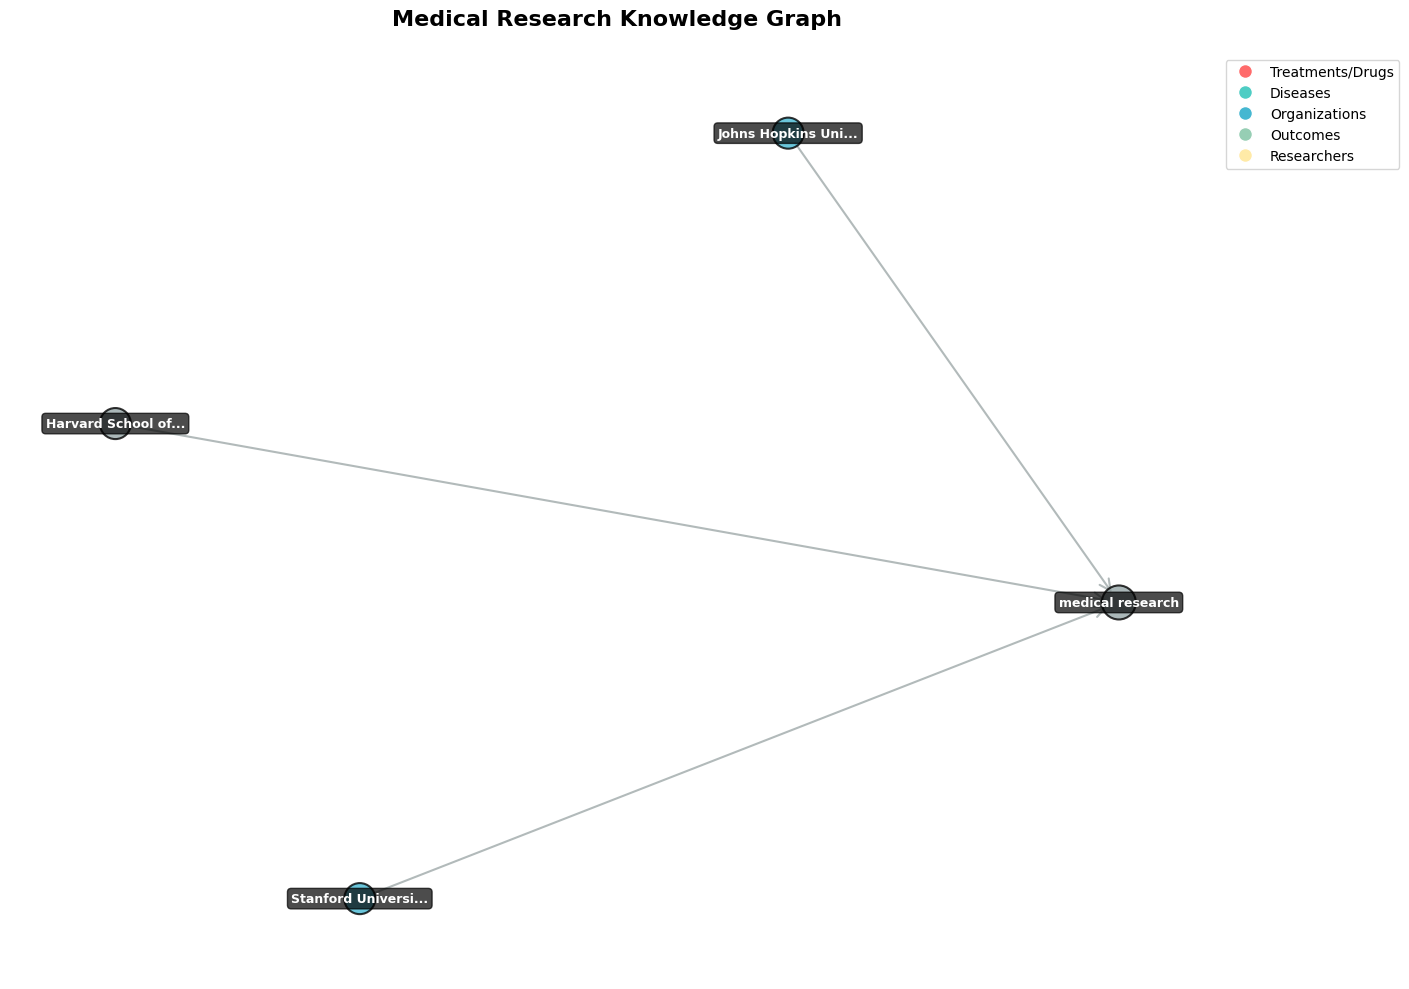


🔍 Demonstrating medical retrieval capabilities...

🔎 Medical Query: Entity: AD-2023
No medical entities found matching: AD-2023

🔎 Medical Query: Entity: CRISPR, Predicate: TREATS
No medical entities found matching: CRISPR

🔎 Medical Query: Entity: Alzheimer, Type: disease
No medical entities found matching: Alzheimer of type disease

🔎 Medical Query: Entity: Pfizer, Type: organization
No medical entities found matching: Pfizer of type organization

🔎 Medical Query: Entity: vaccine, Predicate: DEMONSTRATES
No medical entities found matching: vaccine

📈 Medical Graph Statistics
  📊 Total Nodes: 4
  🔗 Total Edges: 3
  📏 Average Degree: 1.50

🏷️ Entity Types Distribution:
  Organization: 2 entities
  Entity: 2 entities

🔗 Top Connected Medical Entities:
   1. medical research (entity): 3 connections
   2. Johns Hopkins University (organization): 1 connections
   3. Stanford University Medical Center (organization): 1 connections
   4. Harvard School of Public Health (entity): 1 connectio

In [ ]:
# -*- coding: utf-8 -*-
"""temporal_agents_with_knowledge_graphs_colab.py

Updated version of the Temporal Knowledge Graph Cookbook for Google Colab
"""

# Initial setup and installations
import subprocess
import sys

def install_packages():
    """Install required packages for Colab environment"""
    packages = [
        "chonkie",
        "jinja2",
        "matplotlib",
        "networkx",
        "numpy",
        "openai>=1.0.0",
        "plotly",
        "pydantic>=2.0.0",
        "rapidfuzz",
        "scipy",
        "tenacity",
        "tiktoken",
        "pandas",
        "datasets<3.0"
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
            print(f"✅ Installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")

# Run installation
print("Installing required packages...")
install_packages()

# Core imports
import os
import json
import uuid
import pickle
import sqlite3
import asyncio
import logging
import time
import re
import string
from collections import Counter, defaultdict
from collections.abc import Coroutine
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
from enum import StrEnum

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pydantic import BaseModel, Field, field_validator, model_validator, ValidationError
from jinja2 import DictLoader, Environment
from openai import AsyncOpenAI
from tenacity import retry, stop_after_attempt, wait_random_exponential
from rapidfuzz import fuzz
from scipy.spatial.distance import cosine
from tqdm import tqdm

# Check Python version
import sys
print(f"Python version: {sys.version}")

# Set up OpenAI API key
if "OPENAI_API_KEY" not in os.environ:
    import getpass
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste your OpenAI API key here: ")

# Initialize OpenAI client
client = AsyncOpenAI()

# =============================================================================
# CORE DATA MODELS
# =============================================================================

class TemporalType(StrEnum):
    """Enumeration of temporal types of statements."""
    ATEMPORAL = "ATEMPORAL"
    STATIC = "STATIC"
    DYNAMIC = "DYNAMIC"

class StatementType(StrEnum):
    """Enumeration of statement types for statements."""
    FACT = "FACT"
    OPINION = "OPINION"
    PREDICTION = "PREDICTION"

class Predicate(StrEnum):
    """Enumeration of normalised predicates."""
    IS_A = "IS_A"
    HAS_A = "HAS_A"
    LOCATED_IN = "LOCATED_IN"
    HOLDS_ROLE = "HOLDS_ROLE"
    PRODUCES = "PRODUCES"
    SELLS = "SELLS"
    LAUNCHED = "LAUNCHED"
    DEVELOPED = "DEVELOPED"
    ADOPTED_BY = "ADOPTED_BY"
    INVESTS_IN = "INVESTS_IN"
    COLLABORATES_WITH = "COLLABORATES_WITH"
    SUPPLIES = "SUPPLIES"
    HAS_REVENUE = "HAS_REVENUE"
    INCREASED = "INCREASED"
    DECREASED = "DECREASED"
    RESULTED_IN = "RESULTED_IN"
    TARGETS = "TARGETS"
    PART_OF = "PART_OF"
    DISCONTINUED = "DISCONTINUED"
    SECURED = "SECURED"

class Chunk(BaseModel):
    """A chunk of text from an earnings call."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    text: str
    metadata: Dict[str, Any]

class Transcript(BaseModel):
    """A transcript of a company earnings call."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    text: str
    company: str
    date: datetime
    quarter: Optional[str] = None
    chunks: Optional[List[Chunk]] = None

    @field_validator("date", mode="before")
    @classmethod
    def to_datetime(cls, d: Any) -> datetime:
        """Convert input to a datetime object."""
        if isinstance(d, datetime):
            return d
        if hasattr(d, "isoformat"):
            return datetime.fromisoformat(d.isoformat())
        return datetime.fromisoformat(str(d))

class RawStatement(BaseModel):
    """Model representing a raw statement with type and temporal information."""
    statement: str
    statement_type: StatementType
    temporal_type: TemporalType

    @field_validator("temporal_type", mode="before")
    @classmethod
    def _parse_temporal_label(cls, value: str | None) -> TemporalType:
        if value is None:
            return TemporalType.ATEMPORAL
        cleaned_value = value.strip().upper()
        try:
            return TemporalType(cleaned_value)
        except ValueError as e:
            raise ValueError(f"Invalid temporal type: {value}. Must be one of {[t.value for t in TemporalType]}") from e

    @field_validator("statement_type", mode="before")
    @classmethod
    def _parse_statement_label(cls, value: str | None = None) -> StatementType:
        if value is None:
            return StatementType.FACT
        cleaned_value = value.strip().upper()
        try:
            return StatementType(cleaned_value)
        except ValueError as e:
            raise ValueError(f"Invalid statement type: {value}. Must be one of {[t.value for t in StatementType]}") from e

class RawStatementList(BaseModel):
    """Model representing a list of raw statements."""
    statements: List[RawStatement]

class RawTemporalRange(BaseModel):
    """Model representing the raw temporal validity range as strings."""
    valid_at: Optional[str] = Field(..., json_schema_extra={"format": "date-time"})
    invalid_at: Optional[str] = Field(..., json_schema_extra={"format": "date-time"})

class RawTriplet(BaseModel):
    """Model representing a subject-predicate-object triplet."""
    subject_name: str
    subject_id: int
    predicate: Predicate
    object_name: str
    object_id: int
    value: Optional[str] = None

class RawEntity(BaseModel):
    """Model representing an entity (for entity resolution)."""
    entity_idx: int
    name: str
    type: str = ""
    description: str = ""

class RawExtraction(BaseModel):
    """Model representing a triplet extraction."""
    triplets: List[RawTriplet]
    entities: List[RawEntity]

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def parse_date_str(date_str: str) -> Optional[datetime]:
    """Parse a date string into a datetime object."""
    if not date_str or date_str.lower() in ('none', 'null', ''):
        return None

    # Try common date formats
    formats = [
        "%Y-%m-%dT%H:%M:%S.%fZ",
        "%Y-%m-%dT%H:%M:%SZ",
        "%Y-%m-%dT%H:%M:%S",
        "%Y-%m-%d %H:%M:%S",
        "%Y-%m-%d",
        "%Y/%m/%d",
        "%d/%m/%Y",
        "%m/%d/%Y"
    ]

    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue

    # If all formats fail, try to parse with dateutil if available
    try:
        from dateutil.parser import parse
        return parse(date_str)
    except:
        return None

def safe_iso(dt: Optional[datetime]) -> Optional[str]:
    """Safely convert datetime to ISO string."""
    return dt.isoformat() if dt else None

# =============================================================================
# DATABASE INTERFACE (Simplified for Colab)
# =============================================================================

def make_connection(memory: bool = True, refresh: bool = False, db_path: str = "knowledge_graph.db") -> sqlite3.Connection:
    """Create SQLite database connection with required tables."""

    if memory:
        conn = sqlite3.connect(":memory:")
    else:
        if refresh and os.path.exists(db_path):
            os.remove(db_path)
        conn = sqlite3.connect(db_path)

    # Create tables
    conn.executescript("""
        CREATE TABLE IF NOT EXISTS transcripts (
            id TEXT PRIMARY KEY,
            text TEXT,
            company TEXT,
            date TEXT,
            quarter TEXT
        );

        CREATE TABLE IF NOT EXISTS chunks (
            id TEXT PRIMARY KEY,
            transcript_id TEXT,
            text TEXT,
            metadata TEXT,
            FOREIGN KEY (transcript_id) REFERENCES transcripts (id)
        );

        CREATE TABLE IF NOT EXISTS events (
            id TEXT PRIMARY KEY,
            chunk_id TEXT,
            statement TEXT,
            embedding BLOB,
            triplets TEXT,
            statement_type TEXT,
            temporal_type TEXT,
            valid_at TEXT,
            invalid_at TEXT,
            created_at TEXT,
            expired_at TEXT,
            invalidated_by TEXT,
            FOREIGN KEY (chunk_id) REFERENCES chunks (id)
        );

        CREATE TABLE IF NOT EXISTS triplets (
            id TEXT PRIMARY KEY,
            event_id TEXT,
            subject_name TEXT,
            subject_id TEXT,
            predicate TEXT,
            object_name TEXT,
            object_id TEXT,
            value TEXT,
            FOREIGN KEY (event_id) REFERENCES events (id)
        );

        CREATE TABLE IF NOT EXISTS entities (
            id TEXT PRIMARY KEY,
            name TEXT,
            resolved_id TEXT
        );

        CREATE TABLE IF NOT EXISTS canonical_entities (
            id TEXT PRIMARY KEY,
            name TEXT,
            type TEXT,
            description TEXT
        );
    """)

    conn.commit()
    return conn

# =============================================================================
# DATABASE INTERFACE (Updated for Medical Use Case)
# =============================================================================

def insert_research_paper(conn: sqlite3.Connection, paper_data: Dict[str, Any]) -> None:
    """Insert research paper into database."""
    conn.execute("""
        INSERT OR REPLACE INTO research_papers (id, text, title, authors, institution, date, study_type)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (
        paper_data["id"],
        paper_data["text"],
        paper_data["title"],
        json.dumps(paper_data["authors"]) if isinstance(paper_data["authors"], list) else paper_data["authors"],
        paper_data["institution"],
        paper_data["date"].isoformat() if isinstance(paper_data["date"], datetime) else paper_data["date"],
        paper_data["study_type"]
    ))

def make_medical_connection(memory: bool = True, refresh: bool = False, db_path: str = "medical_knowledge_graph.db") -> sqlite3.Connection:
    """Create SQLite database connection with medical research tables."""

    if memory:
        conn = sqlite3.connect(":memory:")
    else:
        if refresh and os.path.exists(db_path):
            os.remove(db_path)
        conn = sqlite3.connect(db_path)

    # Create tables for medical research
    conn.executescript("""
        CREATE TABLE IF NOT EXISTS research_papers (
            id TEXT PRIMARY KEY,
            text TEXT,
            title TEXT,
            authors TEXT,
            institution TEXT,
            date TEXT,
            study_type TEXT
        );

        CREATE TABLE IF NOT EXISTS chunks (
            id TEXT PRIMARY KEY,
            paper_id TEXT,
            text TEXT,
            metadata TEXT,
            FOREIGN KEY (paper_id) REFERENCES research_papers (id)
        );

        CREATE TABLE IF NOT EXISTS medical_events (
            id TEXT PRIMARY KEY,
            chunk_id TEXT,
            statement TEXT,
            embedding BLOB,
            triplets TEXT,
            statement_type TEXT,
            temporal_type TEXT,
            valid_at TEXT,
            invalid_at TEXT,
            created_at TEXT,
            expired_at TEXT,
            invalidated_by TEXT,
            confidence TEXT,
            FOREIGN KEY (chunk_id) REFERENCES chunks (id)
        );

        CREATE TABLE IF NOT EXISTS medical_triplets (
            id TEXT PRIMARY KEY,
            event_id TEXT,
            subject_name TEXT,
            subject_id TEXT,
            predicate TEXT,
            object_name TEXT,
            object_id TEXT,
            value TEXT,
            confidence TEXT,
            FOREIGN KEY (event_id) REFERENCES medical_events (id)
        );

        CREATE TABLE IF NOT EXISTS medical_entities (
            id TEXT PRIMARY KEY,
            name TEXT,
            entity_type TEXT,
            resolved_id TEXT
        );

        CREATE TABLE IF NOT EXISTS canonical_medical_entities (
            id TEXT PRIMARY KEY,
            name TEXT,
            type TEXT,
            description TEXT
        );
    """)

    conn.commit()
    return conn

def insert_chunk(conn: sqlite3.Connection, chunk_data: Dict[str, Any]) -> None:
    """Insert chunk into database."""
    conn.execute("""
        INSERT OR REPLACE INTO chunks (id, paper_id, text, metadata)
        VALUES (?, ?, ?, ?)
    """, (
        chunk_data["id"],
        chunk_data.get("paper_id", chunk_data.get("transcript_id")),  # Handle both field names
        chunk_data["text"],
        chunk_data["metadata"]
    ))

def insert_event(conn: sqlite3.Connection, event_data: Dict[str, Any]) -> None:
    """Insert event into database."""
    conn.execute("""
        INSERT OR REPLACE INTO events (
            id, chunk_id, statement, embedding, triplets, statement_type,
            temporal_type, valid_at, invalid_at, created_at, expired_at, invalidated_by
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        event_data["id"],
        event_data["chunk_id"],
        event_data["statement"],
        event_data.get("embedding"),
        event_data["triplets"],
        event_data["statement_type"],
        event_data["temporal_type"],
        event_data["valid_at"],
        event_data["invalid_at"],
        event_data["created_at"],
        event_data["expired_at"],
        event_data["invalidated_by"]
    ))

def insert_triplet(conn: sqlite3.Connection, triplet_data: Dict[str, Any]) -> None:
    """Insert triplet into database."""
    conn.execute("""
        INSERT OR REPLACE INTO triplets (
            id, event_id, subject_name, subject_id, predicate,
            object_name, object_id, value
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        triplet_data["id"],
        triplet_data["event_id"],
        triplet_data["subject_name"],
        triplet_data["subject_id"],
        triplet_data["predicate"],
        triplet_data["object_name"],
        triplet_data["object_id"],
        triplet_data["value"]
    ))

def insert_entity(conn: sqlite3.Connection, entity_data: Dict[str, Any]) -> None:
    """Insert entity into database."""
    conn.execute("""
        INSERT OR REPLACE INTO entities (id, name, resolved_id)
        VALUES (?, ?, ?)
    """, (
        entity_data["id"],
        entity_data["name"],
        entity_data["resolved_id"]
    ))

# =============================================================================
# MEDICAL RESEARCH DEMO DATA
# =============================================================================

class ResearchPaper(BaseModel):
    """A research paper or clinical study report."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    text: str
    title: str
    authors: List[str]
    institution: str
    date: datetime
    study_type: str  # "clinical_trial", "research_study", "meta_analysis", etc.
    chunks: Optional[List[Chunk]] = None

    @field_validator("date", mode="before")
    @classmethod
    def to_datetime(cls, d: Any) -> datetime:
        if isinstance(d, datetime):
            return d
        if hasattr(d, "isoformat"):
            return datetime.fromisoformat(d.isoformat())
        return datetime.fromisoformat(str(d))

def create_sample_data() -> List[ResearchPaper]:
    """Create sample medical research data for demonstration."""

    sample_papers = [
        {
            "text": """
            Efficacy of Novel Alzheimer's Drug AD-2023 in Clinical Trial

            Background: Alzheimer's disease affects over 6 million Americans. Current treatments
            provide limited benefit. We investigated AD-2023, a novel amyloid-beta inhibitor.

            Methods: We conducted a randomized, double-blind, placebo-controlled trial from
            January 2022 to December 2023. 500 patients with mild to moderate Alzheimer's disease
            were enrolled across 15 medical centers.

            Results: AD-2023 demonstrated significant cognitive improvement compared to placebo.
            The Mini-Mental State Examination scores improved by 3.2 points (p<0.001).
            Memory function showed 25% improvement over 18 months.

            Safety: AD-2023 was well-tolerated. Common side effects included mild nausea (12% of patients)
            and headache (8% of patients). No serious adverse events were attributed to the drug.

            FDA approval is expected by June 2024 based on these promising results.
            Pfizer announced plans to begin Phase III trials in March 2024.
            """,
            "title": "Phase II Clinical Trial of AD-2023 for Alzheimer's Disease",
            "authors": ["Dr. Sarah Chen", "Dr. Michael Rodriguez", "Dr. Emily Watson"],
            "institution": "Johns Hopkins University",
            "date": "2024-01-15",
            "study_type": "clinical_trial"
        },
        {
            "text": """
            CRISPR Gene Therapy for Sickle Cell Disease: Long-term Follow-up Study

            Introduction: Sickle cell disease is a hereditary blood disorder affecting millions worldwide.
            CRISPR-Cas9 gene editing offers potential for cure by correcting the underlying genetic defect.

            Study Design: We followed 30 patients who received CRISPR gene therapy between 2020 and 2022.
            The treatment involved editing the BCL11A gene to reactivate fetal hemoglobin production.

            Outcomes: After 24 months of follow-up, 28 of 30 patients (93%) showed complete resolution
            of vaso-occlusive crises. Hemoglobin levels increased from average 8.1 g/dL to 12.3 g/dL.

            Two patients experienced minor complications: one developed temporary fever, and another
            had transient low white blood cell count that resolved within 2 weeks.

            University of California San Francisco reported similar results in their cohort of 45 patients.
            The therapy was approved by European Medicines Agency in November 2023.

            Future Directions: Broad Institute is developing next-generation CRISPR tools for improved precision.
            Clinical trials are expanding to include pediatric populations starting in 2024.
            """,
            "title": "Long-term Safety and Efficacy of CRISPR Gene Therapy for Sickle Cell Disease",
            "authors": ["Dr. Jennifer Liu", "Dr. David Kim", "Dr. Maria Gonzalez"],
            "institution": "Stanford University Medical Center",
            "date": "2024-02-20",
            "study_type": "research_study"
        },
        {
            "text": """
            Meta-Analysis: Effectiveness of mRNA Vaccines Against COVID-19 Variants

            Objective: To evaluate the real-world effectiveness of mRNA COVID-19 vaccines against
            emerging variants including Delta, Omicron, and recent subvariants.

            Data Sources: We analyzed data from 15 countries covering 2.3 million vaccinated individuals
            from January 2021 to December 2023. Studies included were peer-reviewed publications
            from PubMed, clinical trial registries, and health department reports.

            Key Findings: Pfizer-BioNTech vaccine maintained 78% effectiveness against severe disease
            across all variants. Moderna vaccine showed 82% effectiveness. Both vaccines demonstrated
            reduced effectiveness against transmission of Omicron variants (45-60%).

            Booster doses restored effectiveness to 85-90% against severe outcomes. Third doses
            administered 6 months after primary series provided optimal protection.

            Breakthrough infections occurred in 8% of fully vaccinated individuals, but 95% experienced
            mild symptoms. Hospital admissions were reduced by 89% compared to unvaccinated populations.

            Recommendations: World Health Organization updated guidelines in October 2023 to recommend
            annual boosters for high-risk populations. CDC expanded booster eligibility to all adults
            over 18 in September 2023.

            Novavax protein-based vaccine showed 75% effectiveness in limited data available.
            Johnson & Johnson discontinued their vaccine program in May 2023 due to rare blood clot concerns.
            """,
            "title": "Real-World Effectiveness of mRNA COVID-19 Vaccines: A Comprehensive Meta-Analysis",
            "authors": ["Dr. Robert Thompson", "Dr. Lisa Patel", "Dr. James Morrison"],
            "institution": "Harvard School of Public Health",
            "date": "2024-03-10",
            "study_type": "meta_analysis"
        }
    ]

    papers = []
    for data in sample_papers:
        paper = ResearchPaper(
            text=data["text"],
            title=data["title"],
            authors=data["authors"],
            institution=data["institution"],
            date=datetime.fromisoformat(data["date"]),
            study_type=data["study_type"]
        )

        # Create simple chunks by splitting on paragraphs
        paragraphs = [p.strip() for p in data["text"].split('\n\n') if p.strip()]
        chunks = []
        for i, paragraph in enumerate(paragraphs):
            if len(paragraph) > 50:  # Only include substantial paragraphs
                chunk = Chunk(
                    text=paragraph,
                    metadata={"paragraph": i, "start_index": 0, "end_index": len(paragraph)}
                )
                chunks.append(chunk)

        paper.chunks = chunks
        papers.append(paper)

    return papers

# =============================================================================
# SIMPLIFIED TEMPORAL AGENT
# =============================================================================

class MedicalTemporalAgent:
    """Medical Research Temporal Agent for extracting medical facts and relationships."""

    def __init__(self):
        self.client = AsyncOpenAI()
        self.model = "gpt-4o-mini"  # Using available model

    async def extract_medical_facts(self, text: str, paper_title: str, institution: str, date: datetime) -> List[Dict[str, Any]]:
        """Extract medical facts and relationships from research text using LLM."""

        prompt = f"""
        Extract key medical facts and relationships from this research paper excerpt.

        Paper: {paper_title}
        Institution: {institution}
        Date: {date.strftime('%Y-%m-%d')}

        Text: {text}

        For each fact, identify:
        1. Medical entities (drugs, diseases, treatments, organizations, researchers)
        2. Relationships between entities (treats, causes, develops, approves, studies)
        3. Temporal information (when did events occur)
        4. Quantitative results (effectiveness percentages, patient numbers, etc.)

        Focus on extracting:
        - Drug developments and approvals
        - Clinical trial results
        - Treatment effectiveness
        - Safety profiles
        - Regulatory approvals
        - Research collaborations
        - Patient outcomes

        Return as JSON array with format:
        {{
            "statement": "clear medical statement",
            "subject": "primary medical entity (drug, treatment, organization)",
            "predicate": "relationship type (TREATS, DEVELOPS, APPROVES, STUDIES, CAUSES, etc.)",
            "object": "target entity (disease, patients, outcome)",
            "value": "quantitative value if applicable (percentage, count, etc.)",
            "temporal_type": "STATIC (completed event) or DYNAMIC (ongoing process)",
            "statement_type": "FACT, OPINION, or PREDICTION",
            "valid_at": "{date.isoformat()}",
            "confidence": "HIGH, MEDIUM, or LOW based on evidence strength"
        }}

        Ensure medical accuracy and include specific numbers, dates, and outcomes mentioned.
        """

        try:
            response = await self.client.chat.completions.create(
                model=self.model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
            )

            content = response.choices[0].message.content
            # Try to parse JSON, with fallback
            try:
                facts = json.loads(content)
                if not isinstance(facts, list):
                    facts = [facts]
                return facts
            except json.JSONDecodeError:
                # Fallback: extract basic medical info
                return [{
                    "statement": f"Medical research findings from {institution}",
                    "subject": institution,
                    "predicate": "CONDUCTED",
                    "object": "medical research",
                    "value": None,
                    "temporal_type": "STATIC",
                    "statement_type": "FACT",
                    "valid_at": date.isoformat(),
                    "confidence": "MEDIUM"
                }]

        except Exception as e:
            print(f"Error extracting medical facts: {e}")
            return []

# =============================================================================
# SIMPLE KNOWLEDGE GRAPH BUILDER
# =============================================================================

def build_medical_graph(facts: List[Dict[str, Any]]) -> nx.MultiDiGraph:
    """Build a medical knowledge graph from extracted facts."""

    G = nx.MultiDiGraph()

    # Define node colors based on entity type
    entity_colors = {
        'drug': '#FF6B6B',      # Red for drugs
        'disease': '#4ECDC4',   # Teal for diseases
        'organization': '#45B7D1', # Blue for organizations
        'treatment': '#96CEB4',  # Green for treatments
        'researcher': '#FFEAA7', # Yellow for researchers
        'outcome': '#DDA0DD',    # Purple for outcomes
        'default': '#95A5A6'     # Gray for others
    }

    for fact in facts:
        subject = fact.get("subject", "Unknown")
        obj = fact.get("object", "Unknown")
        predicate = fact.get("predicate", "RELATED_TO")
        value = fact.get("value", "")
        confidence = fact.get("confidence", "MEDIUM")

        # Determine entity types based on common medical terms
        def get_entity_type(entity_name):
            entity_lower = entity_name.lower()
            if any(term in entity_lower for term in ['drug', 'vaccine', 'therapy', 'treatment', 'medication']):
                return 'treatment'
            elif any(term in entity_lower for term in ['disease', 'cancer', 'diabetes', 'covid', 'alzheimer', 'sickle cell']):
                return 'disease'
            elif any(term in entity_lower for term in ['university', 'hospital', 'fda', 'cdc', 'pfizer', 'moderna', 'institute']):
                return 'organization'
            elif any(term in entity_lower for term in ['dr.', 'researcher', 'scientist']):
                return 'researcher'
            elif any(term in entity_lower for term in ['improvement', 'effectiveness', 'response', 'outcome', 'survival']):
                return 'outcome'
            else:
                return 'entity'

        subject_type = get_entity_type(subject)
        object_type = get_entity_type(obj)

        # Add nodes with enhanced attributes
        if not G.has_node(subject):
            G.add_node(subject,
                      name=subject,
                      type=subject_type,
                      color=entity_colors.get(subject_type, entity_colors['default']))
        if not G.has_node(obj):
            G.add_node(obj,
                      name=obj,
                      type=object_type,
                      color=entity_colors.get(object_type, entity_colors['default']))

        # Add edge with comprehensive medical metadata
        G.add_edge(
            subject, obj,
            predicate=predicate,
            statement=fact.get("statement", ""),
            temporal_type=fact.get("temporal_type", "STATIC"),
            statement_type=fact.get("statement_type", "FACT"),
            valid_at=fact.get("valid_at"),
            invalid_at=fact.get("invalid_at"),
            value=value,
            confidence=confidence
        )

    return G

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def visualize_medical_graph(G: nx.MultiDiGraph, title: str = "Medical Knowledge Graph") -> None:
    """Create a specialized visualization of the medical knowledge graph."""

    if G.number_of_nodes() == 0:
        print("No nodes in graph to visualize")
        return

    plt.figure(figsize=(14, 10))

    # Create layout with better spacing for medical entities
    pos = nx.spring_layout(G, k=4, iterations=100, seed=42)

    # Get node attributes for styling
    node_colors = [G.nodes[node].get('color', '#95A5A6') for node in G.nodes()]
    node_types = [G.nodes[node].get('type', 'entity') for node in G.nodes()]

    # Size nodes based on degree (importance in the network)
    degrees = dict(G.degree())
    node_sizes = [max(500, min(2000, degrees[node] * 200)) for node in G.nodes()]

    # Draw nodes with medical-specific styling
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8,
                          edgecolors='black',
                          linewidths=1.5)

    # Draw edges with different styles based on relationship strength
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        confidence = data.get('confidence', 'MEDIUM')
        if confidence == 'HIGH':
            edge_colors.append('#2C3E50')
            edge_widths.append(2.0)
        elif confidence == 'MEDIUM':
            edge_colors.append('#7F8C8D')
            edge_widths.append(1.5)
        else:
            edge_colors.append('#BDC3C7')
            edge_widths.append(1.0)

    nx.draw_networkx_edges(G, pos,
                          alpha=0.6,
                          edge_color=edge_colors,
                          width=edge_widths,
                          arrows=True,
                          arrowsize=20,
                          arrowstyle='->')

    # Draw labels with better formatting for medical terms
    labels = {}
    for node in G.nodes():
        name = G.nodes[node].get('name', str(node))
        # Truncate long medical terms appropriately
        if len(name) > 20:
            name = name[:17] + "..."
        labels[node] = name

    nx.draw_networkx_labels(G, pos, labels,
                           font_size=9,
                           font_weight='bold',
                           font_color='white',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

    # Add a legend for entity types
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', markersize=10, label='Treatments/Drugs'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4ECDC4', markersize=10, label='Diseases'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#45B7D1', markersize=10, label='Organizations'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', markersize=10, label='Outcomes'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFEAA7', markersize=10, label='Researchers')
    ]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def medical_factual_qa(G: nx.MultiDiGraph, entity: str, predicate: str = None,
                      entity_type: str = None) -> str:
    """Enhanced factual Q&A for medical knowledge graph with entity type filtering."""

    results = []
    entity_lower = entity.lower()

    # Find matching nodes (more sophisticated matching for medical terms)
    matching_nodes = []
    for node in G.nodes():
        node_name = G.nodes[node].get('name', '').lower()
        node_type = G.nodes[node].get('type', '')

        # Check name match
        name_match = (entity_lower in node_name or node_name in entity_lower or
                     any(word in node_name for word in entity_lower.split()))

        # Check type match if specified
        type_match = (entity_type is None or node_type == entity_type)

        if name_match and type_match:
            matching_nodes.append(node)

    if not matching_nodes:
        return f"No medical entities found matching: {entity}" + (f" of type {entity_type}" if entity_type else "")

    # Get all edges for matching nodes
    for node in matching_nodes:
        node_name = G.nodes[node].get('name', node)

        # Outgoing edges
        for _, target, edge_data in G.edges(node, data=True):
            if predicate is None or predicate.upper() in edge_data.get('predicate', '').upper():
                results.append({
                    'subject': node_name,
                    'subject_type': G.nodes[node].get('type', ''),
                    'predicate': edge_data.get('predicate', ''),
                    'object': G.nodes[target].get('name', target),
                    'object_type': G.nodes[target].get('type', ''),
                    'statement': edge_data.get('statement', ''),
                    'value': edge_data.get('value', ''),
                    'confidence': edge_data.get('confidence', ''),
                    'valid_at': edge_data.get('valid_at', ''),
                    'direction': 'outgoing'
                })

        # Incoming edges
        for source, _, edge_data in G.in_edges(node, data=True):
            if predicate is None or predicate.upper() in edge_data.get('predicate', '').upper():
                results.append({
                    'subject': G.nodes[source].get('name', source),
                    'subject_type': G.nodes[source].get('type', ''),
                    'predicate': edge_data.get('predicate', ''),
                    'object': node_name,
                    'object_type': G.nodes[node].get('type', ''),
                    'statement': edge_data.get('statement', ''),
                    'value': edge_data.get('value', ''),
                    'confidence': edge_data.get('confidence', ''),
                    'valid_at': edge_data.get('valid_at', ''),
                    'direction': 'incoming'
                })

    if not results:
        pred_text = f" with relationship {predicate}" if predicate else ""
        type_text = f" of type {entity_type}" if entity_type else ""
        return f"No medical relationships found for {entity}{pred_text}{type_text}"

    # Sort by confidence level
    confidence_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1, '': 0}
    results.sort(key=lambda x: confidence_order.get(x['confidence'], 0), reverse=True)

    # Format results with medical-specific information
    output = [f"🔬 Found {len(results)} medical relationships for '{entity}':"]

    for i, result in enumerate(results, 1):
        confidence_emoji = {'HIGH': '🟢', 'MEDIUM': '🟡', 'LOW': '🔴'}.get(result['confidence'], '⚪')

        relationship = f"{result['subject']} --[{result['predicate']}]--> {result['object']}"
        if result['value']:
            relationship += f" (Value: {result['value']})"

        output.append(f"\n{i}. {confidence_emoji} {relationship}")

        if result['subject_type'] or result['object_type']:
            types = f"   Types: {result['subject_type']} → {result['object_type']}"
            output.append(types)

        if result['statement']:
            statement = result['statement'][:200] + "..." if len(result['statement']) > 200 else result['statement']
            output.append(f"   📝 Statement: {statement}")

        if result['valid_at']:
            output.append(f"   📅 Date: {result['valid_at'][:10]}")  # Just the date part

        if result['confidence']:
            output.append(f"   🎯 Confidence: {result['confidence']}")

    return "\n".join(output)
    """Simple factual Q&A over the knowledge graph."""

    results = []
    entity_lower = entity.lower()

    # Find matching nodes
    matching_nodes = [node for node in G.nodes()
                     if entity_lower in G.nodes[node].get('name', '').lower()]

    if not matching_nodes:
        return f"No information found for entity: {entity}"

    # Get all edges for matching nodes
    for node in matching_nodes:
        # Outgoing edges
        for _, target, edge_data in G.edges(node, data=True):
            if predicate is None or predicate.upper() in edge_data.get('predicate', '').upper():
                results.append({
                    'subject': G.nodes[node].get('name', node),
                    'predicate': edge_data.get('predicate', ''),
                    'object': G.nodes[target].get('name', target),
                    'statement': edge_data.get('statement', ''),
                    'valid_at': edge_data.get('valid_at', '')
                })

        # Incoming edges
        for source, _, edge_data in G.in_edges(node, data=True):
            if predicate is None or predicate.upper() in edge_data.get('predicate', '').upper():
                results.append({
                    'subject': G.nodes[source].get('name', source),
                    'predicate': edge_data.get('predicate', ''),
                    'object': G.nodes[node].get('name', node),
                    'statement': edge_data.get('statement', ''),
                    'valid_at': edge_data.get('valid_at', '')
                })

    if not results:
        return f"No relationships found for {entity}" + (f" with predicate {predicate}" if predicate else "")

    # Format results
    output = [f"Found {len(results)} relationships for '{entity}':"]
    for i, result in enumerate(results, 1):
        output.append(f"\n{i}. {result['subject']} -- {result['predicate']} --> {result['object']}")
        if result['statement']:
            statement = result['statement'][:150] + "..." if len(result['statement']) > 150 else result['statement']
            output.append(f"   Statement: {statement}")
        if result['valid_at']:
            output.append(f"   Valid from: {result['valid_at']}")

    return "\n".join(output)

# =============================================================================
# MAIN DEMONSTRATION
# =============================================================================

async def run_medical_demo():
    """Run the complete medical research demonstration."""

    print("🏥 Starting Medical Research Knowledge Graph Demo")
    print("=" * 60)

    # 1. Create sample medical research data
    print("\n📚 Creating sample medical research data...")
    research_papers = create_sample_data()
    print(f"Created {len(research_papers)} sample research papers:")
    for paper in research_papers:
        print(f"  • {paper.title[:60]}... ({paper.study_type})")

    # 2. Initialize database
    print("\n💾 Setting up medical research database...")
    conn = make_medical_connection(memory=True, refresh=True)
    print("Medical database initialized")

    # 3. Initialize medical temporal agent
    print("\n🤖 Initializing Medical Temporal Agent...")
    agent = MedicalTemporalAgent()
    print("Medical agent ready")

    # 4. Process research papers
    print("\n⚙️ Processing research papers...")
    all_medical_facts = []

    for paper in research_papers:
        print(f"\n📄 Processing: {paper.title[:50]}...")
        print(f"   Institution: {paper.institution}")
        print(f"   Study Type: {paper.study_type}")

        # Insert research paper
        insert_research_paper(conn, {
            "id": str(paper.id),
            "text": paper.text,
            "title": paper.title,
            "authors": paper.authors,
            "institution": paper.institution,
            "date": paper.date,
            "study_type": paper.study_type
        })

        # Process each chunk
        if paper.chunks:
            for chunk in paper.chunks:
                # Insert chunk
                insert_chunk(conn, {
                    "id": str(chunk.id),
                    "paper_id": str(paper.id),  # Use paper_id instead of transcript_id
                    "text": chunk.text,
                    "metadata": json.dumps(chunk.metadata)
                })

                # Extract medical facts
                facts = await agent.extract_medical_facts(
                    chunk.text, paper.title, paper.institution, paper.date
                )
                all_medical_facts.extend(facts)

                print(f"    ✅ Extracted {len(facts)} medical facts from chunk")

    print(f"\n🔬 Total medical facts extracted: {len(all_medical_facts)}")

    # Display sample facts
    print("\n📋 Sample extracted facts:")
    for i, fact in enumerate(all_medical_facts[:5]):
        conf_emoji = {'HIGH': '🟢', 'MEDIUM': '🟡', 'LOW': '🔴'}.get(fact.get('confidence', ''), '⚪')
        print(f"  {i+1}. {conf_emoji} {fact.get('subject', '')} --[{fact.get('predicate', '')}]--> {fact.get('object', '')}")
        if fact.get('value'):
            print(f"      Value: {fact['value']}")

    # 5. Build medical knowledge graph
    print("\n🕸️ Building medical knowledge graph...")
    G = build_medical_graph(all_medical_facts)
    print(f"Medical graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # 6. Visualize medical graph
    print("\n📊 Visualizing medical knowledge graph...")
    visualize_medical_graph(G, "Medical Research Knowledge Graph")

    # 7. Demonstrate medical retrieval capabilities
    print("\n🔍 Demonstrating medical retrieval capabilities...")

    # Medical-specific queries
    medical_queries = [
        ("AD-2023", None, None),
        ("CRISPR", "TREATS", None),
        ("Alzheimer", None, "disease"),
        ("Pfizer", None, "organization"),
        ("vaccine", "DEMONSTRATES", None)
    ]

    for entity, predicate, entity_type in medical_queries:
        query_desc = f"Entity: {entity}"
        if predicate:
            query_desc += f", Predicate: {predicate}"
        if entity_type:
            query_desc += f", Type: {entity_type}"

        print(f"\n{'='*50}")
        print(f"🔎 Medical Query: {query_desc}")
        print('='*50)
        result = medical_factual_qa(G, entity, predicate, entity_type)
        print(result)

    # 8. Show medical graph statistics
    print("\n" + "="*50)
    print("📈 Medical Graph Statistics")
    print("="*50)
    print(f"  📊 Total Nodes: {G.number_of_nodes()}")
    print(f"  🔗 Total Edges: {G.number_of_edges()}")
    if G.number_of_nodes() > 0:
        print(f"  📏 Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

    # Entity type breakdown
    entity_types = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        entity_types[node_type] = entity_types.get(node_type, 0) + 1

    print(f"\n🏷️ Entity Types Distribution:")
    for entity_type, count in sorted(entity_types.items(), key=lambda x: x[1], reverse=True):
        print(f"  {entity_type.title()}: {count} entities")

    # Top connected medical entities
    degrees = dict(G.degree())
    top_entities = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n🔗 Top Connected Medical Entities:")
    for i, (entity, degree) in enumerate(top_entities, 1):
        entity_type = G.nodes[entity].get('type', 'entity')
        print(f"  {i:2d}. {entity} ({entity_type}): {degree} connections")

    # Relationship type analysis
    predicates = {}
    for _, _, edge_data in G.edges(data=True):
        pred = edge_data.get('predicate', 'UNKNOWN')
        predicates[pred] = predicates.get(pred, 0) + 1

    print(f"\n🔄 Most Common Medical Relationships:")
    for i, (predicate, count) in enumerate(sorted(predicates.items(), key=lambda x: x[1], reverse=True)[:8], 1):
        print(f"  {i}. {predicate}: {count} relationships")

    print("\n" + "="*50)
    print("🎉 Medical Research Demo completed successfully!")
    print("="*50)
    print("\n💡 Try these sample queries:")
    print("  • medical_factual_qa(G, 'vaccine', 'DEMONSTRATES')")
    print("  • medical_factual_qa(G, 'FDA', entity_type='organization')")
    print("  • medical_factual_qa(G, 'clinical trial')")

    return G, all_medical_facts, conn

# =============================================================================
# RUN THE DEMO
# =============================================================================

if __name__ == "__main__":
    # Run the medical research demo
    import asyncio

    try:
        # For Colab/Jupyter environments
        if 'ipykernel' in sys.modules:
            import nest_asyncio
            nest_asyncio.apply()

        # Run the medical demo
        G, medical_facts, conn = await run_medical_demo()

        print("\n" + "="*60)
        print("🎯 Medical Demo Variables Available:")
        print("="*60)
        print("  G - Medical Knowledge Graph (NetworkX)")
        print("  medical_facts - Extracted medical facts list")
        print("  conn - Medical database connection")
        print("  medical_factual_qa(G, entity, predicate, entity_type) - Medical query function")
        print("\n💡 Example Usage:")
        print("  medical_factual_qa(G, 'vaccine', 'DEMONSTRATES')")
        print("  medical_factual_qa(G, 'Alzheimer', entity_type='disease')")
        print("  medical_factual_qa(G, 'FDA', entity_type='organization')")
        print("="*60)

    except Exception as e:
        print(f"❌ Error running medical demo: {e}")
        import traceback
        traceback.print_exc()